# Laboratory #07 : Image Classification using Bag of Visual Words

At the end of this laboratory, you would get familiarized with

*   Creating Bag of Visual Words
    *   Feature Extraction
    *   Codebook construction
    *   Classification
*   Using pre-trained deep networks for feature extraction

**Remember this is a graded exercise.**

*   For every plot, make sure you provide appropriate titles, axis labels, legends, wherever applicable.
*   Create reusable functions where ever possible, so that the code could be reused at different places.
*   Use will have to mount your drive if you need to access images.

---

In [32]:
# Loading necessary libraries (Feel free to add new libraries if you need for any computation)

import os
import numpy as np
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from skimage.feature import ORB
from skimage.color import rgb2gray
from skimage.io import imread
from skimage import feature

from matplotlib import pyplot as plt

In [33]:
def loadImage(imagePath, gray=False):
    image = imread(imagePath)
    if gray and len(image.shape) > 2:
        image_gray = image
        image_gray = rgb2gray(image_gray)
        return image_gray
    return image

## Loading dataset

We will use 3 categories from Caltech 101 objects dataset for this experiment. Upload the dataset to the drive and mount it.

In [34]:
# modify the dataset variable with the path from your drive

dataset_path = '.'

In [35]:
# creating the list of files and corresponding labels

data = []
labels = []

categories = ['butterfly', 'kangaroo', 'dalmatian']

for idx, cat in enumerate(categories):
    path = os.path.join(dataset_path, cat)
    files_list = os.listdir(path)
    for filename in files_list:
        data.append(os.path.join(path, filename))
        labels.append(idx)

labels = np.array(labels)

print('Total number of images:', len(data))

Total number of images: 244


In [36]:
ncl = len(categories) * 10

In [37]:
# creating train test split



x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

print('Train set:', len(x_train))
print('Test set:', len(x_test))

Train set: 195
Test set: 49


## Feature Extraction using ORB

The first step is to extract descriptors for each image in our dataset. We will use ORB to extract descriptors.

*   Create ORB detector with 64 keypoints.


In [38]:
# solution

orbExtractor = feature.ORB(n_keypoints=64)

*   Extract ORB descriptors from all the images in the train set.
*   Note that, each patch would produce a descriptor of size (256,). So each image would return (N x 256) descriptors, where N is the number of keypoints.

In [39]:
# solution
x_trainOrb = []
for imagePath in tqdm(x_train):
    image = loadImage(imagePath, gray=True)
    orbExtractor.detect_and_extract(image)
    x_trainOrb.append(orbExtractor.descriptors)

100%|██████████| 195/195 [00:45<00:00,  4.26it/s]


In [40]:
# solution
print("number of images: ", len(x_trainOrb))
print("shape of features extracted: ", x_trainOrb[0].shape)
assert x_trainOrb[0].shape == (64, 256)

number of images:  195
shape of features extracted:  (64, 256)


## Codebook Construction

Codewords are nothing but vector representation of similar patches. This codeword produces a codebook similar to a word dictionary. We will create the codebook using K-Means algorithm

*   Create a codebook using K-Means with k=number_of_classes*10
*   Hint: Use sklearn.cluster.MiniBatchKMeans for K-Means

In [41]:
from sklearn.cluster import MiniBatchKMeans

In [42]:
# solution
descriptors = np.vstack(x_trainOrb)
k = len(np.unique(labels))*10
clustering = MiniBatchKMeans(n_clusters=k)
klabels = clustering.fit_predict(descriptors)

*   Create a histogram using the cluster centers for each image descriptor.
    *   Remember the histogram would be of size *n_images x n_clusters*.
    *   Calculate the histogram and divide by the feature length to normalize

In [43]:
# solution
klabels_img = klabels.reshape(-1, 64)
cluster_histograms = []
for image_labels in klabels_img:
    hist, _ = np.histogram(image_labels, bins=k)
    hist = hist / image_labels.shape[0]
    cluster_histograms.append(hist)
dictionary = np.vstack(cluster_histograms)
dictionary.shape

(195, 30)


# Creating Classification Model

*   The next step is to create a classification model. We will use a C-Support Vector Classification for creating the model.



In [44]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [45]:
# note the usage of grid search to select the best parameters

gammas = np.logspace(-6, -1, 10)
C = np.array([0.5, 1, 2, 4, 8, 10, 15, 20, 50, 100, 200, 375, 500, 1000])

svc = SVC(decision_function_shape='ovr')

clf = GridSearchCV(estimator=svc, param_grid=dict(gamma=gammas, C=C), n_jobs=-1)

clf.fit(dictionary, y_train)

print('Best accuracy:', clf.best_score_) 
print('The best value of gamma:', clf.best_estimator_.gamma)
print('The best value of C:', clf.best_estimator_.C)

Best accuracy: 0.5384615384615384
The best value of gamma: 0.1
The best value of C: 50.0


# Testing the Classification Model

*   Extract descriptors using ORB for the test split
*   Use the previously trained k-means to generate the histogram
*   Use the classifier to predict the label


In [46]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [47]:
# solution
x_testOrb = []
for imagePath in tqdm(x_test):
    image = loadImage(imagePath, gray=True)
    orbExtractor.detect_and_extract(image)
    x_testOrb.append(orbExtractor.descriptors)

100%|██████████| 49/49 [00:11<00:00,  4.38it/s]


In [48]:
testklabels = clustering.predict(np.vstack(x_testOrb))

In [49]:
klabels_test_img = testklabels.reshape(-1, 64)
print(klabels_test_img.shape)
test_cluster_histograms = []
for image_labels in klabels_test_img:
    hist, _ = np.histogram(image_labels, bins=k)
    hist = hist / image_labels.shape[0]
    test_cluster_histograms.append(hist)
testdictionary = np.vstack(test_cluster_histograms)
testdictionary.shape

(49, 64)


(49, 30)

In [50]:
predicted_labels = clf.predict(testdictionary)

In [51]:
print(predicted_labels.shape)
print(y_test.shape)

(49,)
(49,)


*   Calculate the accuracy score for the classification model

In [52]:
# solution
print(confusion_matrix(predicted_labels, y_test))
print(f"Classification accuracy: {100*accuracy_score(predicted_labels, y_test):.2f}%")


[[14  4  2]
 [ 4 11  6]
 [ 1  3  4]]
Classification accuracy: 59.18%


*   Why do we use Clustering to create the codebook? 
*   What are the other techniques that can be used to create the codebook?

**Solution**

*(Double-click or enter to edit)*

...

# Extracting features from Deep Network

It is quite possible to extract features (similar to SIFT or ORB) from different layers of deep network.

*   Load ResNet50 model with imagenet weights and check the summary of the model
*   Create a model to extract features from the 'avg_pool' layer.
*   Extract features from the layer for all the train images.

In [98]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import Model

In [99]:
# solution
class embeddingExtractor(Model):
    def __init__(self, *args, **kwargs):
        super(embeddingExtractor, self).__init__()
        self.model = ResNet50(*args, **kwargs)
    
    def extractEmbedding(self, layer):
        return self.model.get_layer(layer).output

    def summary(self):
        return self.model.summary()

    def __call__(self, inputTensor):
        return self.model(inputTensor)

r50 = embeddingExtractor(weights='imagenet', )
# r50.summary()
r50.extractEmbedding('avg_pool')

<tf.Tensor 'avg_pool/Mean_11:0' shape=(None, 2048) dtype=float32>

In [106]:
# solution
embeddings = []
for imagePath in tqdm(x_train):
    image = tf.convert_to_tensor(loadImage(imagePath))
    image = tf.expand_dims(tf.transpose(image, [2, 0, 1]), 0)
    print(image.shape)
    r50(image)
    embedding = r50.extractEmbedding('avg_pool')
    embeddings.append(embedding)

  0%|          | 0/195 [00:00<?, ?it/s](1, 3, 272, 300)



UnimplementedError: The Conv2D op currently does not support grouped convolutions on the CPU. A grouped convolution was attempted to be run because the input depth of 300 does not match the filter input depth of 3 [Op:Conv2D]

*   Create codebook using the extracted features

In [56]:
# solution



In [57]:
# solution



In [58]:
# solution



*   Train SVM classifier using the codebook

In [59]:
gammas = np.logspace(-6, -1, 10)
C = np.array([0.5, 1, 2, 4, 8, 10, 15, 20, 50, 100, 200, 375, 500, 1000])

svc = SVC(decision_function_shape='ovr')

clf = GridSearchCV(estimator=svc, param_grid=dict(gamma=gammas, C=C), n_jobs=-1)

clf.fit(dictionary, y_train)

print('Best accuracy:', clf.best_score_) 
print('The best value of gamma:', clf.best_estimator_.gamma)
print('The best value of C:', clf.best_estimator_.C)

Best accuracy: 0.5384615384615384
The best value of gamma: 0.1
The best value of C: 50.0


*   Evaluate the test set using the above method

In [60]:
# solution



*   Calculate the accuracy score for the classification model

In [61]:
# solution



## t-distributed Stochastic Neighbor Embedding.

In order to visualize the features of a higher dimension data, t-SNE is used. t-SNE converts the affinities of the data points to probabilities. It recreates the probability distribution in a low-dimensional space. It is very helpful in visualizing features of different layers in a neural network.

You can find more information about t-SNE [here](https://scikit-learn.org/stable/modules/manifold.html#t-distributed-stochastic-neighbor-embedding-t-sne)

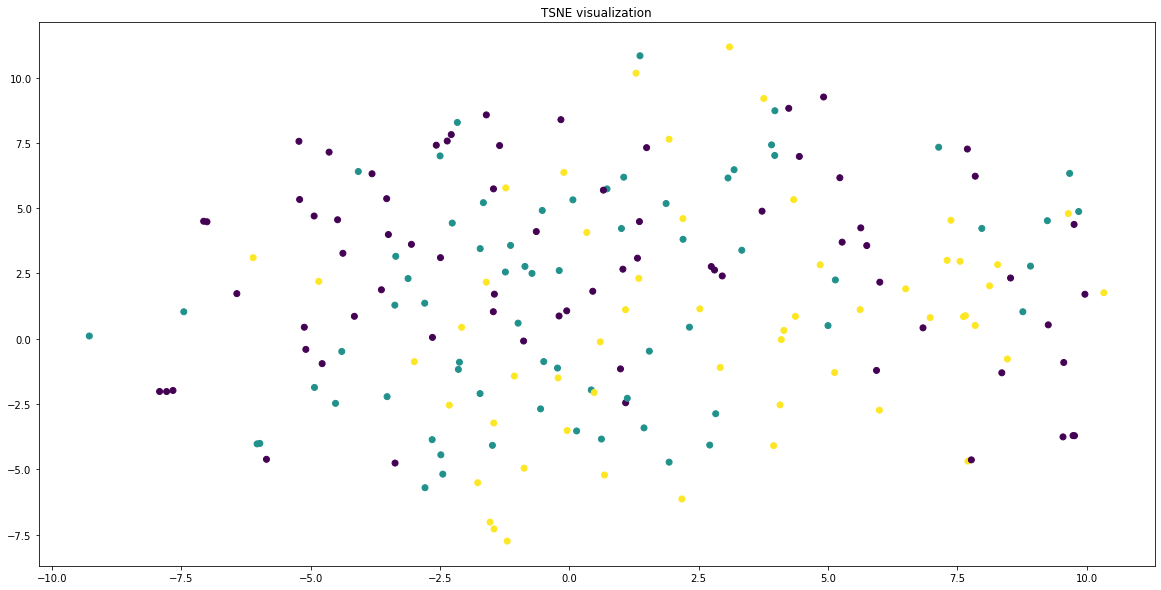

In [62]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0)

np.set_printoptions(suppress=True)

low_embedding = model.fit_transform(dictionary) 

plt.figure(figsize=(20,10))
plt.scatter(low_embedding[:, 0], low_embedding[:, 1], c=y_train)
plt.title("TSNE visualization")
plt.show()

*   What do you infer from the t-SNE plot?

**Solution**

*(Double-click or enter to edit)*

...

*   Compare the performance of both the BoVW models. Which model works better and why?

**Solution**

*(Double-click or enter to edit)*

...

*   Can the performance of pre-trained model increased further? If so, how?

**Solution**

*(Double-click or enter to edit)*

...


---

## **End of P7: Image Classification using Bag of Visual Words**
Deadline for P7 submission in CampusVirtual is: **Thursday, the 26th of November, 2020**